In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pyproj
import numpy as np

In [5]:
import utm

# read data

In [6]:
rock = pd.read_csv('Geochemistry Data/CNS rock samples.csv')

/home/serj/anaconda3/envs/engine/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6,10,16,18,23,37,38,44,45,48,49,58,92,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
prod = pd.read_csv('Production Data/CNS_Field_Production.csv')

# coords to meter

In [8]:
rock['WH_LAT'] = pd.to_numeric(rock['WH_LAT'], errors = 'coerce')

In [9]:
rock = rock.loc[(~rock['WH_LAT'].isnull()) & (~rock['WH_LONG'].isnull()), :]

In [10]:
lat = rock['WH_LAT'].values
long = rock['WH_LONG'].values

In [11]:
x, y, num, let = [], [], [], []
for la, lo in zip(lat, long): 
    res = utm.from_latlon(la, lo, force_zone_number=31, force_zone_letter='V')
    x.append(res[0])
    y.append(res[1])
    num.append(res[2])
    let.append(res[3])

In [12]:
rock['x'] = x
rock['y'] = y

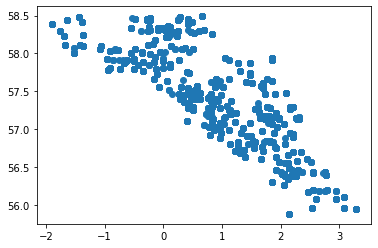

In [13]:
plt.plot(rock['WH_LONG'], rock['WH_LAT'], 'o')

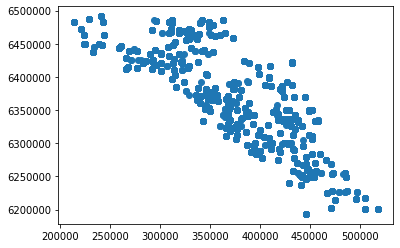

In [14]:
plt.plot(rock['x'], rock['y'], 'o')

In [15]:
rock['SH_DEPTH_TOP_FT'] = pd.to_numeric(rock['SH_DEPTH_TOP_FT'], errors = 'coerce')

In [16]:
rock['SH_DEPTH_TOP_FT'].isnull().sum()

0

# separate rock eval from ooil analyzer

In [17]:
from copy import copy

In [18]:
rockre = rock.loc[(rock['RP_METHOD'].isin(['RockEval', 'Oil analyzer']) ) & (~rock['WH_LAT'].isnull()) & (~rock['WH_LONG'].isnull()), :]

In [19]:
rockre = copy(rockre)

In [20]:
rockre['rp_method_cat'] = rockre['RP_METHOD'].astype('category').cat.codes
rockre['rp_lab_cat'] = rockre['RP_LAB'].astype('category').cat.codes

# check dict

In [21]:
x, y, z = 518069.859848, 6.201034e+06, 10305.45

In [22]:
rockre['distance'] = 0

In [23]:
rockre.loc[:, 'distance'] = ((rockre['x'] - x) ** 2 + (rockre['x'] - x) ** 2 + (rockre['SH_DEPTH_TOP_FT'] - z) ** 2) ** 0.5

In [24]:
rock_feats = [
    'TOC', 'rp_method_cat', 
    'rp_lab_cat', 
    'REV_TOTS1', 'REV_TOTS2', 
    'REV_TOTS3', 'REV_TMAX', 'H_INDEX', 'O_INDEX', 'P_INDEX', 
    'distance'
]

In [25]:
def get_rock_features(x, y, z, formation=None): 
    table_to_search = rockre
    if formation: 
        table_to_search = rockre.loc[rockre['FORMATION'] == formation, :]
    table_to_search.loc[:, 'distance'] = (
        (rockre['x'] - x) ** 2 + (rockre['x'] - x) ** 2 + 
        (rockre['SH_DEPTH_TOP_FT'] - z) ** 2
    ) ** 0.5
    return table_to_search.sort_values('distance').iloc[0][rock_feats]

In [26]:
get_rock_features(518069.859848, 6.201034e+06, 10305.45, formation='Heather Formation')

/home/serj/anaconda3/envs/engine/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


TOC                   2.6
rp_method_cat           0
rp_lab_cat              1
REV_TOTS1            0.81
REV_TOTS2            0.36
REV_TOTS3             NaN
REV_TMAX              422
H_INDEX           13.8462
O_INDEX               NaN
P_INDEX          0.692308
distance          45317.9
Name: 1253, dtype: object

# work with gas

In [27]:
gas = pd.read_csv('Geochemistry Data/CNS_gas_train.csv')

In [28]:
gas = gas.loc[1:, :]

In [29]:
gas['SH_DEPTH_TOP_FT'] = pd.to_numeric(gas['SH_DEPTH_TOP_FT'], errors = 'coerce')

In [30]:
prod['block'] = prod['WELLREGNO'].str.extract('(\d\d\/\d\d\w?)')
prod['block'] = prod['block'].str.lower()

In [31]:
gas['block'] = gas['WH_BLOCK'].str.extract('(\d\d\/\d\d\w?)')
gas['block'] = gas['block'].str.lower()

In [32]:
rockre['block'] = rockre['WELL_NAME'].str.extract('(\d\d\/\d\d\w?)')
rockre['block'] = rockre['block'].str.lower()

In [33]:
welln = set(gas['block'].unique()) & set(rockre['block'].unique()) & set(prod['block'].unique())

In [34]:
prodn = prod[prod['block'].isin(welln)]

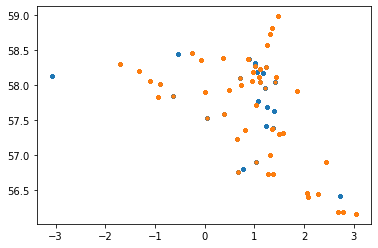

In [35]:
plt.plot(prod['X'], prod['Y'], '.')
plt.plot(prodn['X'], prodn['Y'], '.')

# work with valhall

In [36]:
rockv = rockre[rockre['FORMATION'] == 'Valhall Formation']

In [37]:
gasv = gas[gas['SH_FORM'] == 'Valhall']

In [38]:
gasv['block'].value_counts()

22/30b    105
Name: block, dtype: int64

In [39]:
rockv22 = rockv[rockv['block'] == '22/30b']

In [40]:
rockv22['SH_DEPTH_TOP_FT']

4607    15760.01
4609    15479.99
4610    15439.99
4611    15770.01
4612    15560.01
Name: SH_DEPTH_TOP_FT, dtype: float64

In [41]:
gasv['GAS_ACQ_DATE'].value_counts()

14-07-06 0:00    53
13-01-16 0:00    18
20-07-16 0:00    15
09-06-14 0:00    13
13-01-17 0:00     6
Name: GAS_ACQ_DATE, dtype: int64

In [42]:
gasv[gasv['GAS_ACQ_DATE'] == '14-07-06 0:00']['GAS_C1'].astype(float).mean()

81.83373584905661

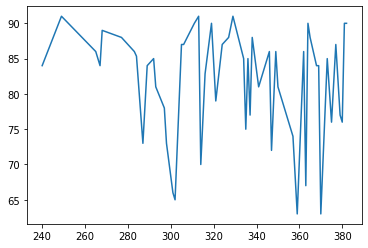

In [43]:
gasv[gasv['GAS_ACQ_DATE'] == '14-07-06 0:00']['GAS_C1'].astype(float).plot()

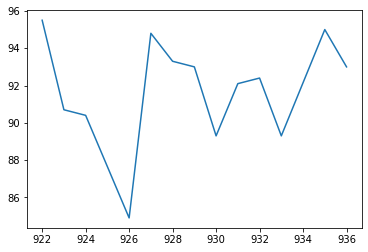

In [44]:
gasv[gasv['GAS_ACQ_DATE'] == '09-06-14 0:00']['GAS_C1'].astype(float).plot()

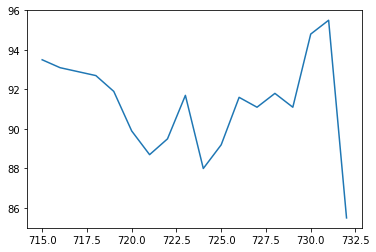

In [45]:
gasv[gasv['GAS_ACQ_DATE'] == '13-01-16 0:00']['GAS_C1'].astype(float).plot()

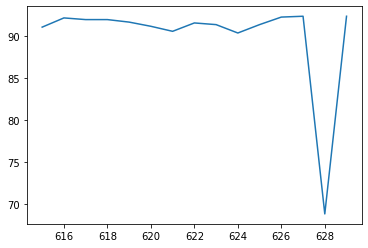

In [46]:
gasv[gasv['GAS_ACQ_DATE'] == '20-07-16 0:00']['GAS_C1'].astype(float).plot()

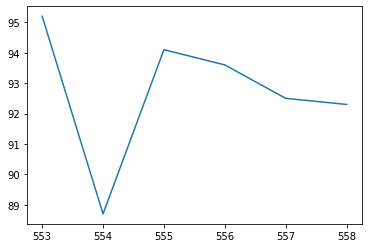

In [47]:
gasv[gasv['GAS_ACQ_DATE'] == '13-01-17 0:00']['GAS_C1'].astype(float).plot()

In [48]:
prod['day'] = 15

In [49]:
prod['date'] = pd.to_datetime({'year': prod['PERIODYR'], 'month': prod['PERIODMNTH'], 'day': prod['day']})

In [50]:
pr22 = prod[prod['block'] == '22/30b'].sort_values(['PERIODYR', 'PERIODMNTH']).reset_index()

In [51]:
pr22['og_re'] = pr22['OILPRODMAS'] / pr22['AGASPRODMA']

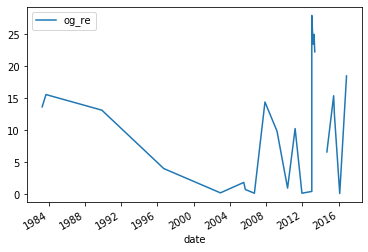

In [52]:
pr22.plot(x='date', y='og_re',)

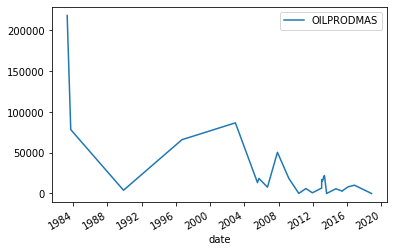

In [53]:
pr22.plot(x='date', y='OILPRODMAS')

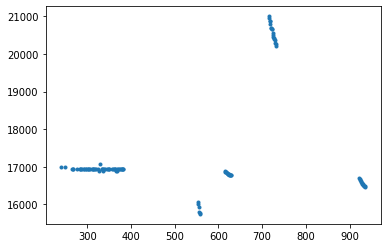

In [54]:
gasv['SH_DEPTH_TOP_FT'].plot(style='.')

In [55]:
gasv['WH_BLOCK'].value_counts()

022/30B EXCL ELGIN    105
Name: WH_BLOCK, dtype: int64

In [56]:
gas['SH_FORM'].value_counts()

HOD                     133
Valhall                 105
Hod                      79
Skagerrak                76
SELE                     73
FULMAR                   71
TOR                      63
Sele                     63
HEATHER                  47
Tor                      47
VALHALL                  41
Heather                  38
Fulmar                   38
Horda                    34
SELE (S1)                32
Pentland                 27
LARK                     27
Kimmeridge Clay          25
KIMMERIDGE CLAY          24
PENTLAND                 24
Lark                     22
HORDA                    22
KIMMERIDGE               20
SKAGERRAK                19
FORTIES                  18
Herring                  17
Ekofisk                  16
JUDY SS                  12
HERRING                  12
VALHAL                   11
                       ... 
HUGIN A                   2
HUGIN B                   2
SELE (S2A)                2
VALHALL CLAY              2
SELE (S2B)          

In [57]:
rockre['FORMATION'].value_counts()

Kimmeridge Clay Formation      2110
Heather Formation               514
Valhall Formation               343
Pentland Formation              324
Fulmar Formation                211
Skagerrak Formation              85
Lossiemouth Formation            79
Smith Bank Formation             68
Ekofisk Formation                63
Piper Formation                  51
Lark Formation                   40
Sele Formation                   33
Dornoch Formation                31
Sele S1                          28
Lista Formation                  26
Rodby Formation                  22
Plenus Marl Formation            21
Volcanics                        20
Horda Formation                  17
Maureen Formation                16
Hidra Formation                  16
Balder Formation                 13
Tor Formation                    13
Rodby R2                         12
Hod Formation                    12
Lower Heather Formation           9
Sele S2b                          9
Kupferschiefer Formation    

In [58]:
rval = rockre[rockre['FORMATION'] == 'Valhall Formation']

In [59]:
rval

,Country,WELL_NAME,OGA Well Name,WH_SITETYPE,WH_FIELD,WH_BLOCK,WH_LAT,WH_LONG,WH_COORD_SYS,WH_OPERATOR,...,SULF_ACQ_DATE,SUL,Unnamed: 104,Unnamed: 105,x,y,rp_method_cat,rp_lab_cat,distance,block
498,United Kingdom,038/01-01,38/1- 1,WELL,NaN,038/01,55.884197,2.137540,World Geodetic System 1984,TEXAS GAS,...,NaN,NaN,NaN,NaN,446050.279506,6.193527e+06,1,1,101955.137561,38/01
532,United Kingdom,030/07a-02,30/7a- 2,WELL,JOANNE,030/07a,56.698476,2.215789,World Geodetic System 1984,PHILLIPS,...,NaN,NaN,NaN,NaN,451976.813332,6.284097e+06,1,1,93509.968187,30/07a
533,United Kingdom,030/07a-02,30/7a- 2,WELL,JOANNE,030/07a,56.698476,2.215789,World Geodetic System 1984,PHILLIPS,...,NaN,NaN,NaN,NaN,451976.813332,6.284097e+06,1,1,93508.514026,30/07a
534,United Kingdom,030/07a-02,30/7a- 2,WELL,JOANNE,030/07a,56.698476,2.215789,World Geodetic System 1984,PHILLIPS,...,NaN,NaN,NaN,NaN,451976.813332,6.284097e+06,0,1,93511.150450,30/07a
535,United Kingdom,030/07a-02,30/7a- 2,WELL,JOANNE,030/07a,56.698476,2.215789,World Geodetic System 1984,PHILLIPS,...,NaN,NaN,NaN,NaN,451976.813332,6.284097e+06,1,1,93509.121520,30/07a
578,United Kingdom,030/06-03,30/6- 3,WELL,030/06-03A,030/06,56.808485,2.074547,World Geodetic System 1984,SHELL,...,NaN,NaN,NaN,NaN,443493.205646,6.296450e+06,1,1,105498.978909,30/06
1275,United Kingdom,030/18-03,30/18- 3,WELL,Orion,030/18,56.426859,2.545919,World Geodetic System 1984,TENNECO,...,NaN,NaN,NaN,NaN,471993.020376,6.253682e+06,1,1,65204.297009,30/18
1276,United Kingdom,030/18-03,30/18- 3,WELL,Orion,030/18,56.426859,2.545919,World Geodetic System 1984,TENNECO,...,NaN,NaN,NaN,NaN,471993.020376,6.253682e+06,1,1,65209.839829,30/18
1277,United Kingdom,030/18-03,30/18- 3,WELL,Orion,030/18,56.426859,2.545919,World Geodetic System 1984,TENNECO,...,NaN,NaN,NaN,NaN,471993.020376,6.253682e+06,1,1,65206.106328,30/18
1278,United Kingdom,030/18-03,30/18- 3,WELL,Orion,030/18,56.426859,2.545919,World Geodetic System 1984,TENNECO,...,NaN,NaN,NaN,NaN,471993.020376,6.253682e+06,1,1,65207.953936,30/18


# ll

In [60]:
prod['date'] = pd.to_datetime({'year': prod['PERIODYR'], 'month': prod['PERIODMNTH'], 'day': 15})

In [61]:
gasd = gas.loc[~gas['SH_CDATE'].isnull(), :]

In [62]:
gasd['date_real'] = pd.to_datetime(gasd['SH_CDATE'])

/home/serj/anaconda3/envs/engine/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
gasd['date'] = pd.to_datetime({
    'year': gasd['date_real'].apply(lambda x: x.year), 
    'month': gasd['date_real'].apply(lambda x: x.month), 
    'day': 15, 
})

/home/serj/anaconda3/envs/engine/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [64]:
gasd['date']

1      2016-03-15
2      2016-03-15
3      2016-09-15
4      2016-02-15
5      2016-02-15
6      2016-02-15
7      2016-02-15
8      2016-02-15
9      2016-02-15
10     2016-02-15
11     2016-02-15
12     2016-02-15
13     2016-02-15
14     2016-02-15
15     2016-02-15
16     2016-02-15
17     2016-02-15
18     2016-02-15
19     2016-02-15
20     2016-02-15
21     2016-02-15
22     2016-02-15
23     2016-02-15
24     2016-02-15
25     2016-02-15
26     2016-02-15
27     2016-02-15
28     2016-02-15
29     2016-02-15
45     2007-12-15
          ...    
1636   2012-09-15
1637   2012-09-15
1638   2012-09-15
1639   2012-09-15
1640   2012-09-15
1641   2012-09-15
1642   2012-09-15
1643   2012-08-15
1644   2012-08-15
1645   2012-12-15
1646   2012-12-15
1647   2012-12-15
1648   2012-11-15
1649   2012-11-15
1650   2012-07-15
1651   2012-07-15
1652   2012-07-15
1653   2012-07-15
1654   2012-07-15
1655   2012-11-15
1656   2012-10-15
1657   2012-09-15
1658   2012-09-15
1659   2012-07-15
1660   201

In [65]:
prod.index = prod[['date', 'block']]

In [66]:
prod = prod.reset_index(drop=True)

In [67]:
gas_f = ['GAS_C1','GAS_C2','C2_UNSAT','GAS_C3','C3_UNSAT','GAS_IC4','GAS_NC4','C4_UNSAT','GAS_NEOC5','GAS_IC5','GAS_NC5','C5_UNSAT','GAS_NC5_PLUS','GAS_C6PLUS','GAS_O2','GAS_CO2']

In [68]:
for g in gas_f: 
    gasd[g] = pd.to_numeric(gasd[g], errors = 'coerce')

/home/serj/anaconda3/envs/engine/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [69]:
gasd_mean = gasd.groupby(['date', 'block'])[gas_f].mean()

In [70]:
gasd_mean = gasd_mean.reset_index()

In [87]:
prod_blocks = {}
for i, g in prod.groupby('block'): 
    prod_blocks[i] = g.sort_values('date').reset_index(drop=True)

In [92]:
gasd_blocks = {}
for i, g in gasd_mean.groupby('block'): 
    gasd_blocks[i] = g.sort_values('date').reset_index(drop=True)

In [98]:
work_on = list(set(gasd_blocks.keys()) & set(prod_blocks.keys()))

In [99]:
prod_blocks[work_on[0]]

,X,Y,OBJECTID,FIELDNAME,FIELDAREA,ORGGRPNM,UNITNAME,UNITTYPCOD,UNITTYPDES,LOCATION,...,INJWATMASS,INJWATVOL,INJWATMBD,WATPRODMAS,WATPRODVOL,WATPRODMBD,WELLREGNO,block,day,date
0,1.322034,58.735792,6169,BRAE-SOUTH [Part of BRAE],CNS,ROCKROSE ENERGY,BRAE SOUTH,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,259.0,259.0,0.054304,21/25-B2Z,21/25,15,1983-09-15
1,0.010229,57.897786,7613,BUCHAN,CNS,BP EXPLORATION,BUCHAN,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,3677.0,3677.0,0.746075,21/25-A2,21/25,15,1985-08-15
2,2.686525,56.189296,12229,DUNCAN,CNS,ENQUEST PLC,DUNCAN,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,40677.0,40677.0,8.253495,21/25-G7,21/25,15,1989-03-15
3,2.686525,56.189296,12230,DUNCAN,CNS,ENQUEST PLC,DUNCAN,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,36543.0,36543.0,7.661849,21/25-G8,21/25,15,1989-04-15
4,2.686525,56.189296,12231,DUNCAN,CNS,ENQUEST PLC,DUNCAN,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,51468.0,51468.0,10.443023,21/25-G8Z,21/25,15,1989-05-15
5,2.686525,56.189296,12236,DUNCAN,CNS,ENQUEST PLC,DUNCAN,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,24823.0,24823.0,5.036667,21/25-G2,21/25,15,1989-10-15
6,1.322034,58.735792,5859,BRAE-NORTH [Part of BRAE],CNS,ROCKROSE ENERGY,BRAE NORTH,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,45164.0,45164.0,9.163921,21/25-B4,21/25,15,1993-05-15
7,1.322034,58.735792,6321,BRAE-SOUTH [Part of BRAE],CNS,ROCKROSE ENERGY,BRAE SOUTH,P,Oil Field Exporting to Pipeline,Offshore,...,187789.0,187789.0,38.102994,111140.0,111140.0,22.550665,21/25-A7,21/25,15,1996-05-15
8,1.446503,58.111837,11307,CYRUS,CNS,BP EXPLORATION,CYRUS,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,60215.0,60215.0,12.217818,21/25-T1,21/25,15,1998-07-15
9,1.857774,57.922604,11806,DRAKE,CNS,ROYAL DUTCH SHELL,DRAKE,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.000000,2135.0,2135.0,0.447638,21/25-G1,21/25,15,1999-09-15


In [85]:
for p in prod_blocks: 
    print()

,X,Y,OBJECTID,FIELDNAME,FIELDAREA,ORGGRPNM,UNITNAME,UNITTYPCOD,UNITTYPDES,LOCATION,...,INJWATMASS,INJWATVOL,INJWATMBD,WATPRODMAS,WATPRODVOL,WATPRODMBD,WELLREGNO,block,day,date
0,1.178426,58.175376,3745,BEAULY,CNS,REPSOL SINOPEC RESOURCES,BEAULY,P,Oil Field Exporting to Pipeline,Offshore,...,0.0,0.0,0.0,24886.0,24886.0,5.217765,202/04- 1,02/04,15,2005-09-15


In [241]:
list(prod)

['X',
 'Y',
 'OBJECTID',
 'FIELDNAME',
 'FIELDAREA',
 'ORGGRPNM',
 'UNITNAME',
 'UNITTYPCOD',
 'UNITTYPDES',
 'LOCATION',
 'PERIODDATE',
 'PERIODYRMN',
 'PERIODMNTH',
 'PERIODMNNM',
 'PERIODYR',
 'OILPRODMAS',
 'OILPRODM3',
 'OILPRDDENS',
 'OILPRODMBD',
 'DGASPRODMA',
 'DGASPROKSM',
 'DGASPROMMS',
 'DGASPRODEN',
 'AGASPRODMA',
 'AGASPROMMS',
 'AGASPROKSM',
 'AGASPRODEN',
 'GCONDMASS',
 'GCONDVOL',
 'GCONDMBD',
 'GCONDDEN',
 'INJWATMASS',
 'INJWATVOL',
 'INJWATMBD',
 'WATPRODMAS',
 'WATPRODVOL',
 'WATPRODMBD',
 'WELLREGNO',
 'block',
 'day',
 'date']

In [242]:
prod['og_d'] = prod['OILPRODMAS'] / prod['AGASPRODMA']

22/06a


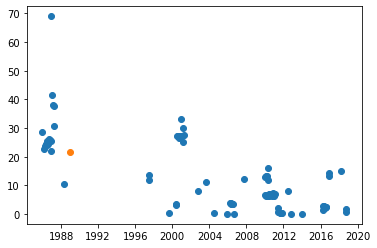

23/22a


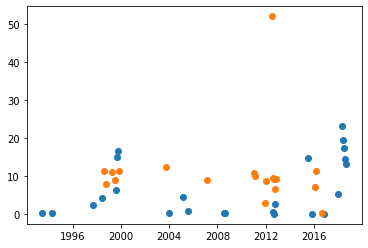

23/27


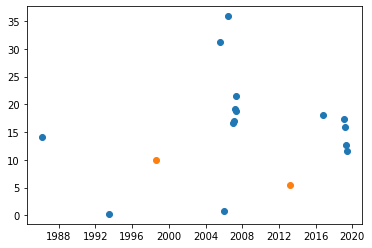

23/27a


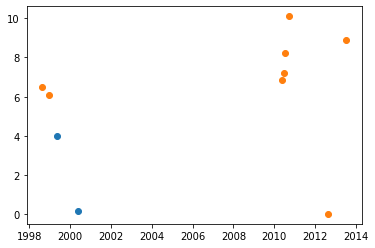

22/30b


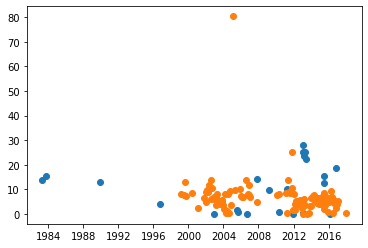

29/03a


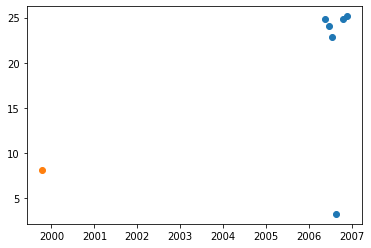

22/29


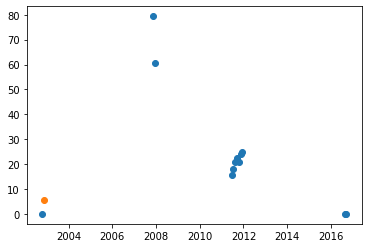

14/29a


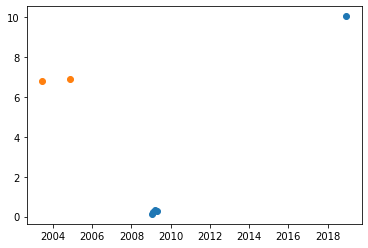

22/30a


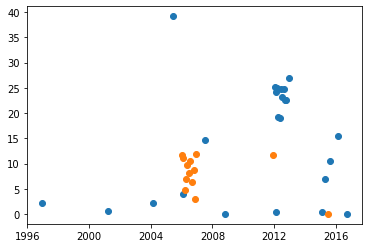

21/30d


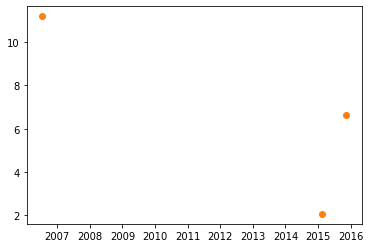

29/07a


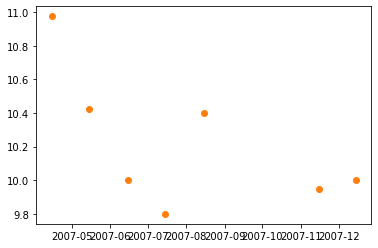

21/25


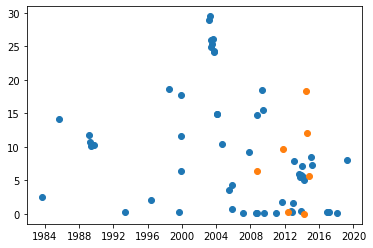

22/21


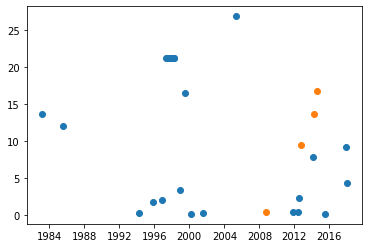

22/13a


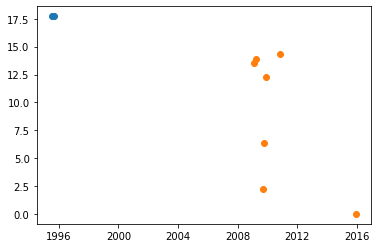

29/03c


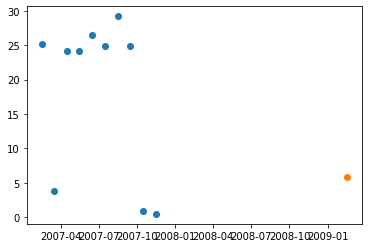

22/12a


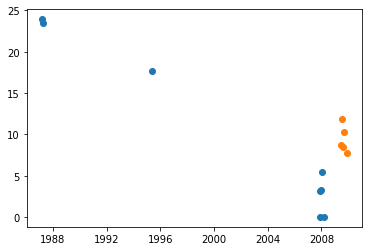

22/12c


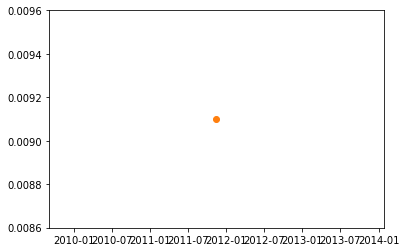

22/24d


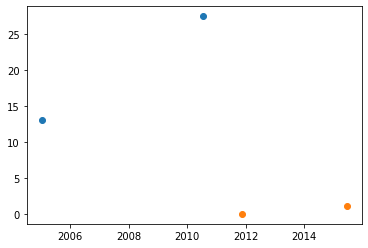

21/20b


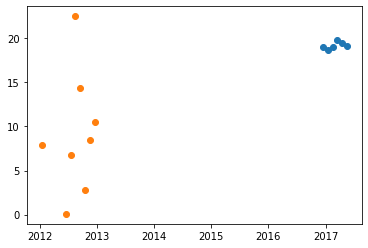

21/20a


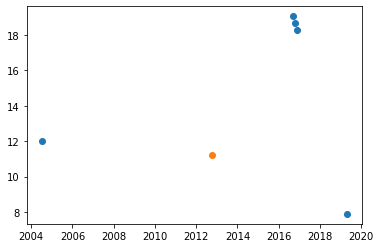

22/11a


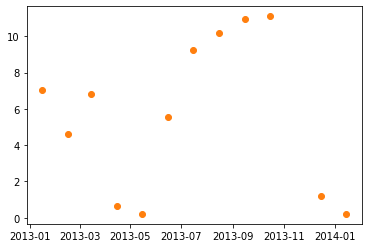

21/25b


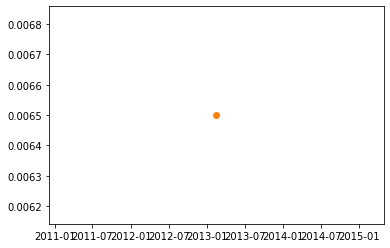

21/30b


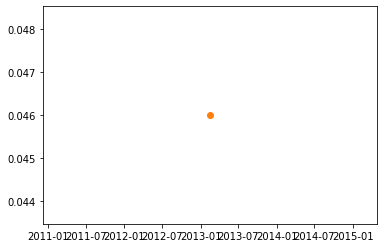

21/25a


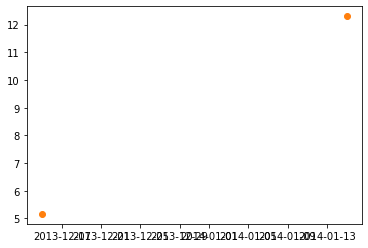

22/11


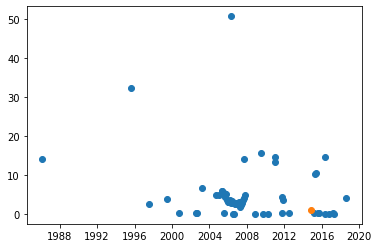

21/30f


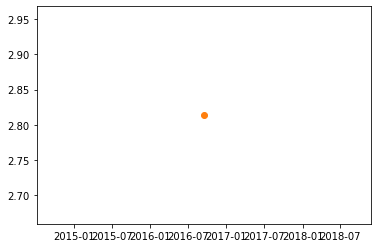

In [249]:
for block in gasd_mean['block'].unique(): 
    print(block)
    plt.plot(prod[prod['block'] == block]['date'], prod[prod['block'] == block]['og_d'], 'o')
    plt.plot(gasd_mean[gasd_mean['block'] == block]['date'], gasd_mean[gasd_mean['block'] == block]['GAS_C2'], 'o')
    
    plt.show()